In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import DataSplitter
import utils

In [2]:
df60 = DataSplitter.getTrainData(60)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

# Naive benchmark

RangeIndex(start=14660, stop=14680, step=1)
RangeIndex(start=14700, stop=14720, step=1)
RangeIndex(start=14740, stop=14760, step=1)
RangeIndex(start=14780, stop=14800, step=1)
RangeIndex(start=14820, stop=14840, step=1)
RangeIndex(start=14860, stop=14880, step=1)
RangeIndex(start=14900, stop=14920, step=1)
RangeIndex(start=14940, stop=14960, step=1)
RangeIndex(start=14980, stop=15000, step=1)
RangeIndex(start=15020, stop=15040, step=1)
RangeIndex(start=15060, stop=15080, step=1)
RangeIndex(start=15100, stop=15120, step=1)
RangeIndex(start=15140, stop=15160, step=1)
RangeIndex(start=15180, stop=15200, step=1)
RangeIndex(start=15220, stop=15240, step=1)
RangeIndex(start=15260, stop=15280, step=1)
RangeIndex(start=15300, stop=15320, step=1)
RangeIndex(start=15340, stop=15360, step=1)
RangeIndex(start=15380, stop=15400, step=1)
RangeIndex(start=15420, stop=15440, step=1)
RangeIndex(start=15460, stop=15480, step=1)
RangeIndex(start=15500, stop=15520, step=1)
RangeIndex(start=15540, stop=155

/var/folders/93/9bwp5y9s6p925yjm6qkgky980000gn/T/ipykernel_64133/1734980844.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  preds_1step = pd.concat([preds_1step, pred])
/var/folders/93/9bwp5y9s6p925yjm6qkgky980000gn/T/ipykernel_64133/1734980844.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_val_pred = pd.concat([y_val_pred, preds_1step])


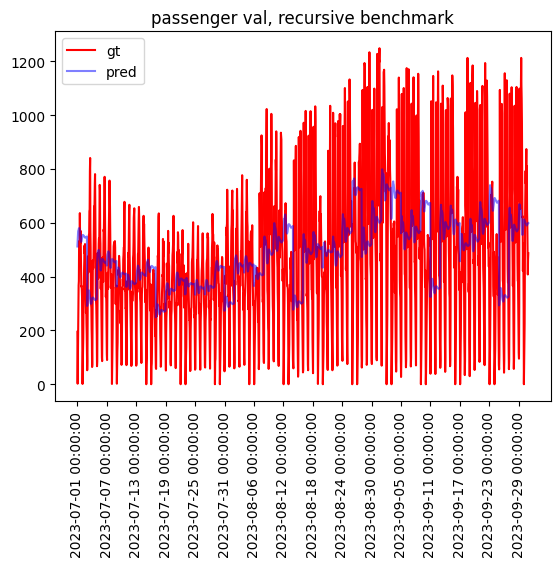

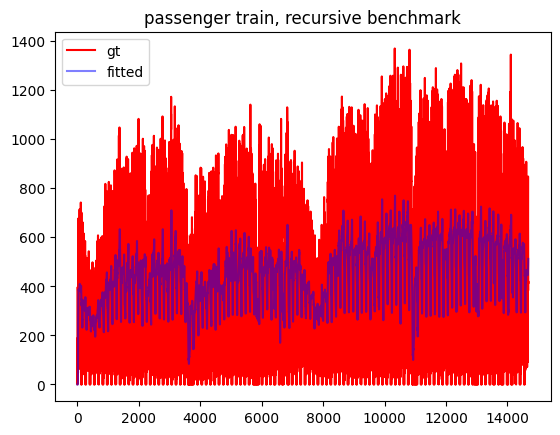

In [68]:
horizon = 40
window_size = 20
y_val_pred = pd.Series()
indexrange = range(y_val.index[0], y_val.index[-1] + 1, horizon)

# concat all train and val data so it can be subsetted on window
X_sliding = pd.concat([X_train, X_val])
y_sliding = pd.concat([y_train, y_val])

timer = utils.Time()
timer.start()
for idx, time in enumerate(indexrange):
    # subset on window size
    y_temp = y_sliding.loc[time - window_size : time-1]
    print(y_temp.index)

    preds_1step = pd.Series()
    for i in range(0, horizon):
        # 1 step prediction
        pred = pd.Series(y_temp.mean(), index=[time+i])

        # add new prediction and discard first datapoint
        y_temp = pd.concat([y_temp, pred])[1:]
        preds_1step = pd.concat([preds_1step, pred])

    y_val_pred = pd.concat([y_val_pred, preds_1step])
print(timer.end())

# train predictions as rolling mean
y_train_pred = y_train.rolling(window=window_size).mean().fillna(0)

# round and cut off train and val predictions
y_train_pred = y_train_pred.round()
y_train_pred[y_train_pred < 0] = 0
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive benchmark')
plt.legend()
plt.show()

plt.plot(X_train.index, y_train, color='red', label='gt')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
plt.title('passenger train, recursive benchmark')
plt.legend()
plt.show()

# Lasso

/Users/andreasskibyandersen/Library/Mobile Documents/com~apple~CloudDocs/Universitet/6_Semester/Bachelor/Machine-Learning-Passenger-Forecasting/utils.py:91: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_val_pred = pd.concat([y_val_pred, preds])


Execution time: 0.276 sec
train MAE%: 0.155
train MAPE: 0.34
train RMSE%: 0.216
val MAE%: 0.348
val MAPE: 0.666
val RMSE%: 0.45


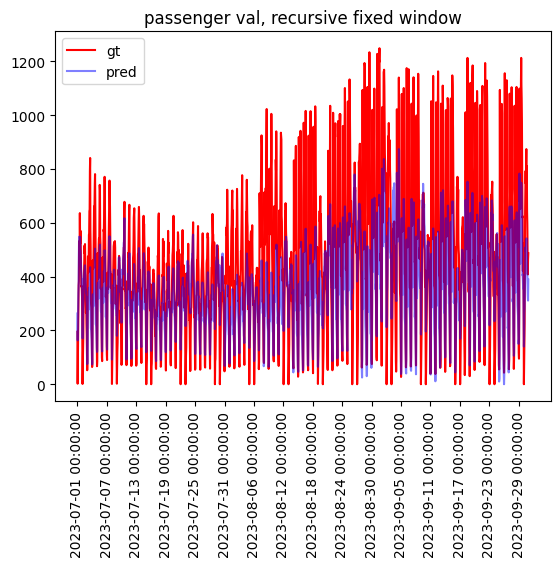

                            OLS Regression Results                            
Dep. Variable:     passengersBoarding   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     4532.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:38:51   Log-Likelihood:                -86262.
No. Observations:               14680   AIC:                         1.726e+05
Df Residuals:                   14650   BIC:                         1.728e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  147.0074 

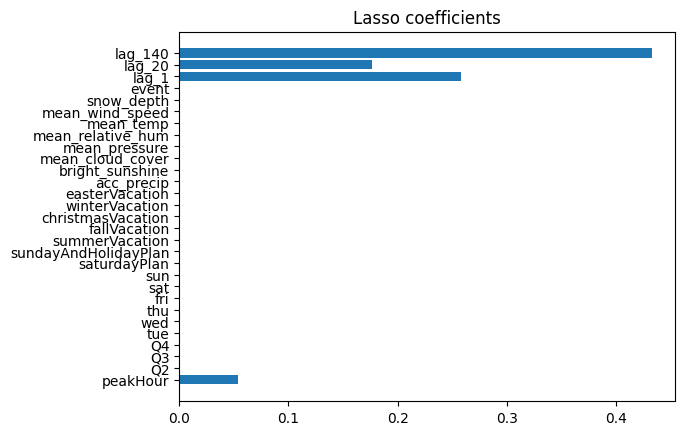

In [8]:
# fixed window forecast (reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1

model = Lasso(alpha=0.1)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

# Use statsmodels to perform OLS regression and output summary
X_train_lagged = X_train.copy(deep=True)
if lags:
    for lag in lags:
        X_train_lagged[f'lag_{lag}'] = y_train.shift(periods=lag).fillna(0)
ols_model = sm.OLS(y_train, sm.add_constant(X_train_lagged)).fit()
print(ols_model.summary())

plt.barh(X_train_lagged.columns, model.coef_)
plt.title('Lasso coefficients')
plt.show()